In [1]:
import sys
sys.path.append('/home/skw24/python_modules')
import os

import pandas as pd
import numpy as np
import re
from list_extension import List
import misc
import math
import functools
import converter
import json
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
%matplotlib inline


from lazy1 import Data

added DDR as DDR
added kinases as kinases
added oncs as oncs
added tsgs as tsgs
added muts as muts
added CosmicCompleteGeneExpression as ge
added gene_multi_converter1 as conv
added fprints_12_Sept_2019 as fprints
added signature_descriptions as descriptions
added sig_breakdown_across_cosmic_21feb as breakdown
added gene_path as gene_path
added cosmic_mutations_and_triplets as quads
added ensgs_to_seq as ensgs_seq
added pathogenic_mutation_IDs as pathogenic_mutation_IDs
added pathogenic_quads as path_quads
added tcga_samples as tcga_samples
added TCGA_muts as TCGA_muts
added COSM_reps as COSM_reps
added TCGA_onc_muts as TCGA_onc_muts
added TCGA_tsg_muts as TCGA_tsg_muts
added correlations as correlations
added alignments_df as alignments_df
added genes_for_consideration as genes_for_consideration
added sig_probs as sig_probs
added samples as samples
added mutations_with_partial_mutations_and_ensts_tcga as partials
added common_partials_tcga as common_partials


In [215]:
fingerprints = Data.fprints()
fingerprints.columns = [','.join(list(i.replace(',','')))
                        for i in fingerprints.columns]


# Purpose

The purpose of this notebook is to answer the question..

'Why does KRAS has a G12R mutation in pancreatic cancer, but other cancers have a G12D mutation?

This question was broadened out to ask the more general question:

'Are there many common mutations that take a different form in different cancers'


# Helper functions

In [216]:
quadruplets =pd.Series([a+b+c+d for a in 'ACGT' for b in 'CT' for c in 'ACGT' for d in 'ACGT' if b!=c])
quadruplets_sorted = quadruplets[quadruplets.map(lambda x: x[1:3]+x[0]+x[3]).sort_values().index].values

def plot_quads(series, short = False,ax ='',plot = False):
    params = {False:(6,['C>A','C>G','C>T','T>A','T>C','T>G']), 
              True:(4,['C>A','C>G','C>T','T>A'])}

    colors = []
    for c in ['blue','black','red','gray','green','pink']:
        for i in range(16):
            colors.append(c)
    if type(ax)==str:
        fig,ax = plt.subplots(figsize = (10,3))
    
    ax= series.plot(kind = 'bar',ax = ax, color = colors)
    ax.set_xticks([i*16+8 for i in range(params[short][0])])
    ax.set_xticklabels(params[short][1],rotation = 0);
    if plot:
        plt.show()
    return ax

add = lambda mylist: reduce(lambda x,y:x+y,mylist)

## First step - loading the mutations

In [217]:
def make_partials():
    '''load the CosmicGenomeScreensMutantExport.tsv, 
    clean the data a little, filter for substitutions
    and then add in a couple of columns, partial_mutation 
    and complete_mutation both for the full and partial gene
    name.Note that this data is saved directly and can then 
    be loaded using Data.partials()
    
    '''
    
    #load the whole genome mutations
    df = Data.muts()
    #filter for substitutions
    df = df.loc[df['Mutation Description'].map(
        lambda x: 'substitution' in x.lower())]
    #keep columns of interest
    df = df[['Sample name','Primary site','Mutation CDS', 
             'Mutation AA','Mutation genome position', 
             'Mutation strand', 
             'FATHMM prediction', 'FATHMM score',
             'Gene name','Accession Number']]

    df.dropna(how = 'any',inplace = True)

    #for some purposes it is important to have the full enst code, for others not - so here we do both
    df['Gene name'] = df['Gene name'].map(
        lambda x: x.split('_')[0])
    df['name']=df['Gene name']+'_'+df['Accession Number']
    complete_mutation_full = df['name']+':'+df['Mutation AA']
    partial_mutation_full = complete_mutation_full.map(lambda x:x[:-1])
    df['partial_mutation_full_name'] = partial_mutation_full
    df['complete_mutation_full_name'] = complete_mutation_full
    
    complete_mutation = df['Gene name']+':'+df['Mutation AA']
    partial_mutation = complete_mutation.map(lambda x:x[:-1])
    df['partial_mutation'] = partial_mutation
    df['complete_mutation'] = complete_mutation
    
    #drop all the duplicate entries
    df  = df.drop_duplicates(subset = ['Sample name','Mutation AA','name'])
    
    #filter for samples with fingerprints
    available_samples = set(Data.fprints().index)
    df = df.loc[df['Sample name'].map(lambda x: x in available_samples)]
    
    df = df.loc[df['Sample name'].map(lambda x:x in fingerprints.index)]
    
    df.to_csv('mutations_with_partial_mutations_and_ensts.csv')
    df = df.loc[df['Sample name'].map(lambda x:x[:4]=='TCGA')]
    df.to_csv('mutations_with_partial_mutations_and_ensts_tcga.csv')

In [4]:
df = pd.read_csv('mutations_with_partial_mutations_and_ensts.csv',index_col = 0)

/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
make_partials()
Data.add('mutations_with_partial_mutations_and_ensts_tcga.csv',
         'auto','partials')

# common partials

we want to identify those partial mutations that occur in 100 samples or more 
so firstly we identify the mutations by the gene name taking out any references to enst
and by the position.

at this stage we save it for lazy loading later.

In [13]:
def make_common_partials():
    partial_vc = Data.partials()['partial_mutation'].value_counts()
    common_vc = partial_vc[partial_vc>100]
    common_partials = Data.partials().loc[Data.partials()['partial_mutation'].map(lambda x: x in common_vc.index)]
    common_partials.to_csv('common_partials_tcga.csv')

In [14]:
make_common_partials()

In [11]:
Data.add('common_partials_tcga.csv','auto','common_partials')

In [218]:
set_common_partials = set(Data.common_partials()\
                          ['partial_mutation'])

In [219]:
def make_enst_options():
    '''uses Data.partials to identify 
    the most commonly mutated gene positions and the list of 
    associated gene_ensts that we need in order to'''
    
    freq_of_muts = Data.common_partials()\
        ['partial_mutation_full_name'].value_counts()
    gene_ensts = pd.Series(freq_of_muts.index.map(
        lambda x: x.split('_')[0]+':'+x.split(':')[-1]))
    gene_ensts.index = freq_of_muts.index
    ge = pd.DataFrame(gene_ensts)
    ge_groups = pd.Series(ge.groupby(by=0).groups).\
        map(lambda x:list(x))
    freq_of_short_muts = ge_groups.map(lambda x: sum([freq_of_muts[i] for i in x]))
    options = pd.DataFrame({'options':ge_groups,'frequency':freq_of_short_muts})
    options = options.sort_values(by = 'frequency', ascending = False)
    frequent_options = options.loc[options['frequency']>100]
    frequently_mutated_genes = set(frequent_options.index.map(lambda x: x.split(':')[0]))
    frequent_options.to_csv('enst_options_tcga.csv')
    
    

In [21]:
make_enst_options()

Data.add('enst_options_tcga.csv','auto','enst_options')

genes_with_commonly_mutated_sites = set(
    Data.enst_options().index.map(lambda x:x.split(':')[0]))

In [221]:
print(genes_with_commonly_mutated_sites)

{'TP53', 'KRAS', 'BRAF', 'NRAS', 'IDH1', 'PIK3CA'}


TP53 KRAS BRAF NRAS IDH1 and PIK3CA have these commonly mutated sites

In [222]:
gene_mutation_split =pd.DataFrame(list(Data.enst_options().index.map(lambda x: x.split(':'))), 
             columns = ['Gene','mutations'])

# we are interested in just those amino acids which are commonly mutated in more than one way

In [824]:
class Gene_mut:
    
    '''Given a partial mutation, identify all the mutations
    that include it and split them
    by the resulting amino acid, 
    and primary site.'''
    
    
    comp = {'A':'T','T':'A','C':'G','G':'C'}
    
    dic ={'AAA': 'K', 'AAC': 'N', 'AAG': 'K', 'AAT': 'N', 'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T', 'AGA': 'R',
    'AGC': 'S', 'AGG': 'R', 'AGT': 'S', 'ATA': 'I', 'ATC': 'I', 'ATG': 'M', 'ATT': 'I', 'CAA': 'Q', 'CAC': 'H', 'CAG': 'Q',
    'CAT': 'H', 'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P', 'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R', 'CTA': 'L',
    'CTC': 'L', 'CTG': 'L', 'CTT': 'L', 'GAA': 'E', 'GAC': 'D', 'GAG': 'E', 'GAT': 'D', 'GCA': 'A', 'GCC': 'A', 'GCG': 'A',
    'GCT': 'A', 'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G', 'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V', 'TAA': '*',
    'TAC': 'Y', 'TAG': '*', 'TAT': 'Y', 'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S', 'TGA': '*', 'TGC': 'C', 'TGG': 'W',
    'TGT': 'C', 'TTA': 'L', 'TTC': 'F', 'TTG': 'L', 'TTT': 'F'}
    
    # re code for finding wild and mutant
    code = re.compile('^c\.\d+([ACGT])>([ACGT])$')
    
    #function for finding DNA converse string
    rev_comp = lambda string: ''.join([Gene_mut.comp[i] for i in string][::-1])
    
    with open('/home/skw24/Data1/enst_sequences.json') as f:
        seqs = pd.Series(json.load(f))

    
    
    def chromos(i):
        '''if a chromosome is not already in the dictionary 
        then load it on demand'''
        
        if '_chromos' not in Gene_mut.__dict__:
            Gene_mut._chromos = {}
        if i not in Gene_mut._chromos:
            with open(os.path.join(Data.root,
            'Homo_sapiens.GRCh38.dna.chromosome.{}.seq'\
                                   .format(i))) as f:
                Gene_mut._chromos[i] = f.read()
        return Gene_mut._chromos[i]

    def cos_sim(a,b):
        return np.dot(a,b)/math.sqrt(np.dot(a,a)*np.dot(b,b))
    
        
    def __init__(self,mut):
        '''mut of form BRAF_ENST00000288602:p.V600 '''
        
        self.mut = mut
        self.wild = mut.split('.')[1][0]
        self.complete_mutations,self.gene,self.example_aa,self.perc_comparison,self.comparison,self.df,self.strand = self.make_comparisons()
        self.mutant_df,self.chromosome = self.set_mutant_df()
        self.quads = dict(zip(self.mutant_df['Mutation CDS'].values,self.mutant_df['quads'].values))
        self.aas = dict(zip(self.mutant_df['quads'].values,self.mutant_df['Mutation AA'].values))
        self.possible_mutations = self.set_possible_mutations()
        
    def make_comparisons(self):
    
        df = Data.common_partials().loc[(Data.common_partials()['partial_mutation_full_name']== self.mut)]
        strand = df['Mutation strand'].iloc[0]
        complete_mutations = df[['Primary site','complete_mutation_full_name']]

        breakdown = complete_mutations.groupby(complete_mutations.columns.tolist())
        breakdown = breakdown.size().reset_index().rename(columns={0:'records'})
        breakdown = breakdown.sort_values(by = ['Primary site', 'records'],ascending = False)

        comparison = breakdown.pivot(index = 'Primary site', 
                                     columns = 'complete_mutation_full_name', 
                                     values = 'records').fillna(0).astype(int)
        comparison.columns = [i.split(':')[1] for i in comparison.columns]

        perc_comparison = comparison.apply(lambda row: (100*row/row.sum()).astype(int), axis = 1)
        perc_comparison['total'] = comparison.T.sum()

        comp= complete_mutations['complete_mutation_full_name'].iloc[0]
        gene,example_aa = comp.split(':')


        return complete_mutations,gene,example_aa,perc_comparison,comparison,df,strand
    
    def get_aa_quad(self,i,m):
        #make mutated codon
        w = self.codon[i]
        if m!=w:
            codon_list =list(self.codon)
            codon_list[i]=m
            mut_codon = ''.join(codon_list)
            #find associated aa
            mut_aa = Gene_mut.dic[mut_codon]

            triplet = list(self.five[i:i+3])
            #find associated quad
            mut_quad0 = triplet[:2]+[m]+triplet[-1:]
            if w in 'CT':
                mut_quad = ','.join(mut_quad0)
            else:
                mut_quad=','.join([Gene_mut.comp[mut_quad0[i]] for i in [3,1,2,0]])
            return [w,m,i,mut_aa,mut_quad]
        else: 
            return [np.nan,np.nan,np.nan,np.nan,np.nan]

        
    def set_possible_mutations(self):

        self.enst = self.gene.split('_')[1]
        self.aa_pos = int(self.mut.split('.')[1][1:])
        c = Gene_mut.seqs[self.enst][3*(self.aa_pos-1):3*self.aa_pos]
        self.codon = c
        self.five = Gene_mut.seqs[self.enst][3*(self.aa_pos-1)-1:3*self.aa_pos+1]
        columns = ['wild','mutant','register','mut_aa','mut_quad']
        values = [self.get_aa_quad(i,N) for i in range(3) for N in 'ACGT']
        return pd.DataFrame(values,columns = columns).dropna(
            how = 'any').astype({'register':int})
    
    
    def set_mutant_df(self):

        #pick out the columns that describe the mutation
        mutant_df0 = self.df[['Mutation AA','Mutation CDS','Mutation genome position']].drop_duplicates()

        def wild_mut(x):
            match = Gene_mut.code.match(x)
            if match:
                w,m =(match.groups())
                if w in 'CT':
                    return [w,m]
                else:
                    return [Gene_mut.comp[w],Gene_mut.comp[m]]
            else:
                return [np.nan,np.nan]
        
        #make a dataframe of the wild and mutated substitutions 
        wm = pd.DataFrame(list(mutant_df0['Mutation CDS'].map(wild_mut)),
                          columns = ['wild','mutant'],
                          index = mutant_df0.index)
        
        def chromo_pos(x):
            cp = x.split('-')[0].split(':')
            return [int(i) for i in cp]

        #make a dataframe of all the chromosome positions split into chromosome (c) and position
        cp  = pd.DataFrame(list(mutant_df0['Mutation genome position'].map(chromo_pos)),
                           columns = ['chromo','pos'],
                           index = mutant_df0.index)
        #concatenate the three together
        mutant_df1 =  pd.concat([mutant_df0[['Mutation AA','Mutation CDS']],wm,cp],axis = 1).reset_index()
        wmcp = mutant_df1[['wild','mutant','chromo','pos']]
        
        #find the quads from the chromosome reference and adjust for the chromosome strand
        def quad(row):
            w,m,c,p = row
            triplet = Gene_mut.chromos(c)[p-2:p+1]
            if triplet[1] not in 'CT':
                triplet = Gene_mut.rev_comp(triplet)
            return ','.join(list(triplet[:2]+m+triplet[2]))

        quads = wmcp.apply(quad,axis = 1)
        quads.name = 'quads'
        mutant_df = pd.concat([mutant_df1,quads],axis=1)
        mutant_df.drop('index',axis = 1,inplace = True)
        chromosome = mutant_df.iloc[0]['chromo']
        return mutant_df,chromosome
    
           
            
    def predict(self,site):
        #find the samples with cancer at the primary site
        site_samples = self.df.loc[self.df['Primary site']==site][['Sample name','Mutation CDS']].drop_duplicates()
        all_samples = set(site_samples['Sample name'])
        self.all_samples = all_samples

        #provide a pd.series of all the quads and resulting amino acid
        q_a = self.mut.split(':')[1]+self.possible_mutations['mut_aa']
        q_a.index = self.possible_mutations['mut_quad']
        #take out the silent mutations
        silent = self.mut.split(':')[1]+self.wild
        q_a = q_a[q_a!=silent]
        self.q_a = q_a
        #get the fingerprints of all the samples that have a substitution mutation in the
        #right place, right site
        self.fingerprints = fingerprints.reindex(all_samples)
        fp = self.fingerprints.sum().reindex(q_a.index).fillna(0)
        fp = fp//fp.index.value_counts()
        fp.index = q_a.values
        fp = fp.groupby(level=0).sum()

        prediction = pd.DataFrame({'exp':(fp/fp.sum()*self.comparison.loc[site].sum()),
                      'obs':self.comparison.loc[site].reindex(fp.index).fillna(0)})

        return prediction 

        
        
    def predict2(self,site):
        try:
            site_samples = self.df.loc[self.df['Primary site']==site][['Sample name','Mutation CDS']].drop_duplicates()
            all_samples = set(site_samples['Sample name'])
            just_gene_fingerprints = fingerprints.reindex(all_samples).dropna()
            all_gene_fingerprints = fingerprints.reindex(Data.tcga_samples()[site]).dropna()

            #list of all possible quads
            mut_quad = list(self.possible_mutations['mut_quad'])

            #some of these quads may give rise to more than one aa so we count these
            diff_aas = self.possible_mutations['mut_quad'].value_counts().reindex(mut_quad)

            #opportunities for mutations giving rise to the mut_quad
            ops_just_gene = just_gene_fingerprints[mut_quad].sum()/diff_aas #looking only at the fingerprints with 
            #a mutation in the gene
            ops_all_gene = all_gene_fingerprints[mut_quad].sum()/diff_aas #looking at all the fingerprints in the tissue type

            #provide a pd.series of all the quads and resulting amino acid
            q_a = self.mut.split(':')[1]+self.possible_mutations['mut_aa']
            q_a.index = self.possible_mutations['mut_quad']


            fprint_counts = pd.concat([ops_just_gene,ops_all_gene,q_a],axis=1).groupby(by = 'mut_aa').sum()
            fprint_counts.columns = ['expectation','gene_non_specific_exp']

            #take out the silent substitutions
            fprint_counts = fprint_counts.reindex([i for i in fprint_counts.index if i[2]!=i[-1]])

            #observation
            obs = self.comparison.loc[site].reindex(fprint_counts.index).fillna(0)
            obs.name = 'observation'

            fprint_counts = fprint_counts.apply(lambda col:col/col.sum()*obs.sum())
            prediction = fprint_counts.T.append(obs).T
            prediction['site'] = site
        except:
            prediction = pd.DataFrame(columns = ['expectation','gene_non_specific_exp','obs','site'])

        return prediction

In [834]:
class AllGeneMuts:
    
    def __init__(self,gene_mut):
        self.gene_mut = gene_mut
        self.enst_muts = eval(Data.enst_options().loc[
            self.gene_mut].iloc[0])       
        self.enst_muts = [i for i in self.enst_muts if 
                          'ENST' in i]
        self.gene_muts = self.get_gene_muts()

        if len(self.gene_muts)>0:
            self.df = Data.common_partials().loc[
                Data.common_partials()[
                    'partial_mutation_full_name'].map(
                    lambda x:x in self.enst_muts)]

            self.df.drop_duplicates(subset = 'Sample name',
                                    inplace = True)
            self.sites = self.df['Primary site'].value_counts()
            self.common_sites = self.sites[self.sites>1]
            if self.common_sites.shape[0]>0:
                self.predictions =self.predict()

    def get_gene_muts(self):
        gene_muts = []
        for enst_mut in self.enst_muts:
            try:
                gene_muts.append(Gene_mut(enst_mut))
            except (KeyError, AssertionError):
                pass
        return gene_muts
    
    def predict(self):
        preds = pd.concat([i.predict2(site) for i 
                           in self.gene_muts for site in self.common_sites.index])
        preds['index_col'] = preds.index
        predictions = preds.groupby(by = ['index_col','site']).sum()

        ratio_specific = predictions['observation']/predictions['expectation']
        ratio_specific.name = 'ratio_specific'
        ratio_non_specific = predictions['observation']/predictions['gene_non_specific_exp']
        ratio_non_specific.name = 'ratio_non_specific'
        predictions = pd.concat([predictions,ratio_specific,ratio_non_specific],axis=1)
        predictions = pd.DataFrame(predictions.to_records())
        return predictions
    
    def weight(self,row):
        info= row[:2]
        values= row[2:5]
        factor = self.common_sites[info[1]]
        return info.append(factor*values)


    def get_weights(self):
        weighted_sites = []
        for site in self.common_sites.index:
            site_pred = self.predictions.loc[self.predictions['site']==site]
            site_pred.index = site_pred['index_col']
            weighted_site = site_pred.apply(self.weight,axis=1)
            weighted_sites.append(weighted_site)

        weighted_sites = pd.concat(weighted_sites)
        weighted_sites['aa mutation'] = weighted_sites['index_col']
        ws = 100*weighted_sites.groupby(by = 'aa mutation').sum()
        ws/=ws.sum()
        return ws

    def get_perc_accounted(self,col):
        def account(row):
            '''The amount accounted for of the observation by the expected result'''
            a,b = row
            return min(a,b)

        x = self.weighted.iloc[:,[col,2]]
        return x.apply(account,axis = 1).sum()
    
    
    
    
    def show(self):
        try:
            size = self.common_sites.shape[0]
            fig,axarr = plt.subplots(size, figsize = (6,4*size),dpi = 72)

            for i,s in  enumerate(self.common_sites.index):
                
                if size>1:
                    ax = axarr[i]
                else:
                    ax = axarr
                
                preds = self.common_predictions.loc[self.common_predictions['site']==s]
                ax = preds.iloc[:,:2].plot(kind = 'bar',ax = ax)
                ax.set_title(s)
            plt.tight_layout()
            fig.suptitle(self.gene_mut.replace(':p.','_'),y = 1.02,size =20)

            return fig
        except AttributeError:
            pass
        
    def save_data(self):

        '''identify the data within the class and save it. Capable of saving 
        strings, floats,ints, lists and sets of json-serializable data,
        as well as dataframes and series.'''

        #make necessary paths
        object_path = os.path.join(os.getcwd(),'objects_AllGeneMuts')

        try:
            os.mkdir(object_path)
        except FileExistsError:
            pass

        self.path = os.path.join(object_path,self.gene_mut)
        try:
            os.mkdir(self.path)
        except FileExistsError:
            pass

        keys = list(self.__dict__.keys())

        other_dic = {}
        self.type_dic = dict([(k,eval(str(type(self.__dict__[k])).replace('<class','').replace('>',''))) for k in keys])


        for key in keys:
            if self.type_dic[key] in ['pandas.core.frame.DataFrame','pandas.core.series.Series']:
                getattr(self,key).to_csv(os.path.join(self.path,'{}.csv'.format(key)))
            if self.type_dic[key]=='set':
                other_dic[key] = list(getattr(self,key))
            elif self.type_dic[key] in ['str', 'float','int']:
                other_dic[key] = getattr(self,key)
            if self.type_dic[key] in 'list':
                temp = getattr(self,key)
                if len(temp)>0:
                    if type(temp[0]) in [dict,list,str,float,int]:
                        other_dic[key] = getattr(self,key)
            if self.type_dic[key] == 'dict':
                temp = getattr(self,key)[0]
                if len(temp.keys())>0:
                    if type(list(temp.values())[0]) in [dict,list,str,float,int]:
                        other_dic[key] = getattr(self,key)

        with open(os.path.join(self.path,'other_dic.json'),'w') as f:
            json.dump(other_dic,f)

In [835]:
def get_u_m_l(col):

    '''get experimental statistics - here the upper and lower bound of the data , the median and the 
    weight that should be given to the statistics. The weight in this case is given as 1/variance'''
    if True in set(col.isnull()):
        return pd.Series({'upper':np.nan,'median':np.nan,'lower':np.nan,'weight':np.nan},name = col.name)
    else:
        length = col.shape[0]
        sort = col.sort_values()
        sort.index = range(length)

        q1 = sort[length//4]
        median = sort[length//2]
        q3 = sort[(3*length)//4]
        iqr = q3-q1
        lower = max(q1-1.5*(iqr),col.min())
        upper = min(q3+1.5*(iqr),col.max())
        weight = 1/col.var()

        return pd.Series({'upper':upper,'median':median,'lower':lower,'weight':weight},name = col.name)

def forest(experimental_df,sample_sizes):


    u_m_l = experimental_df.apply(get_u_m_l)

    weighted = u_m_l.iloc[:-1]*u_m_l.loc['weight']

    weighted_stats = weighted.T.sum()/u_m_l.loc['weight'].sum()

    u_m_l.drop('weight',axis=0,inplace = True)

    weighted = pd.concat([u_m_l,weighted_stats],axis=1,sort=True).T

    weighted.rename(index ={0: 'weighted_stats'},inplace = True)
    sizes = 1000*(sample_sizes/sample_sizes.sum())

    if not ax:
        fig,ax = plt.subplots()

    Y = weighted.shape[0]
    ax.axvline(x = weighted.iloc[-1]['median'], color = 'blue',linestyle = '--',alpha =0.5)
    ax.axvline(x = 0, color = 'gray')

    for i,s in enumerate(weighted.index[:-1]):  

        x = weighted.iloc[i][['lower','upper']]
        if True in set(x.isnull()):
            ax.axhline(y = Y+1-i,color = 'black', alpha = 0.3)
            ax.scatter(x = 0,y = Y+1-i, marker = 's',s = sizes[s],alpha = 0.3)

        else:
            ax.hlines(y = Y+1-i, xmin = x[0],xmax = x[1])
            ax.scatter(x = weighted.iloc[i]['median'],y = Y+1-i, marker = 's',s = sizes[s],alpha = 1)

    ax.hlines(y = 1, xmin = weighted.iloc[-1]['lower'],xmax = weighted.iloc[-1]['upper'])
    ax.scatter(x = weighted.iloc[-1]['median'],y = 1, marker = 'D',s = 1000,alpha = 1)



    _ = ax.set_yticklabels(['weighted_stats',' ']+list(weighted.index[:-1][::-1]))
    _= ax.set_yticks(range(1,Y+2))
    _ax = ax.set_title(title,fontsize = 14)
    if xlim:
        ax.set_xlim(xlim)
    else:
        mx = max([abs(i) for i in ax.get_xlim()])
        ax.set_xlim(-mx,mx)
    return ax


def forest_plot(experimental_df,
            sample_sizes,
            ax=None,
            title = None,
            title_size = 12,
            xlim = None,
            size_scale=10):


    '''When given a dataframe providing the logarithmic odds ratios for a series of experiments, 
    and the sample_sizes of those experiments, this function plots the forest_plot.

        The forest plot, is rotated so that the outcome variable is shown along the horizontal axis 
        and the studies are arranged vertically.  
        The squares represent the odds ratios for the three individual studies. The area of the square is proportionate
        to the sample size.
        The horizontal lines give their confidence intervals, either from Q1-1.5*IQR to Q3+1.5*IQR or the limit of 
        the data whichever is most limiting.  

    Inputs: 

    Experimental_df - DataFrame, columns - experiment names, rows - experiment values, values - logarithm of
    odds ratio.

    Sample_sizes - Series, index - experiment names, values - sample sizes.

    ax - optional - returns matplotlib ax object

    title - optional.


        '''
    u_m_l = experimental_df.apply(get_u_m_l)

    weighted = u_m_l.iloc[:-1]*u_m_l.loc['weight']

    weighted_stats = weighted.T.sum()/u_m_l.loc['weight'].sum()

    u_m_l.drop('weight',axis=0,inplace = True)

    weighted = pd.concat([u_m_l,weighted_stats],axis=1,sort=True).T

    weighted.rename(index ={0: 'weighted_stats'},inplace = True)
    scale = 10*size_scale*size_scale
    sizes = scale*(sample_sizes/sample_sizes.sum())

    if not ax:
        fig,ax = plt.subplots()

    Y = weighted.shape[0]
    ax.axvline(x = weighted.iloc[-1]['median'], color = 'blue',linestyle = '--',alpha =0.5)
    ax.axvline(x = 0, color = 'gray')

    for i,s in enumerate(weighted.index[:-1]):  

        x = weighted.iloc[i][['lower','upper']]
        if True in set(x.isnull()):
            ax.axhline(y = Y+1-i,color = 'black', alpha = 0.3)
            ax.scatter(x = 0,
                       y = Y+1-i, 
                       marker = 's',
                       s = sizes[s],
                       alpha = 0.3)

        else:
            ax.hlines(y = Y+1-i, xmin = x[0],xmax = x[1])
            ax.scatter(x = weighted.iloc[i]['median'],
                       y = Y+1-i, 
                       marker = 's',
                       s = sizes[s],
                       alpha = 1)

        ax.hlines(y = 1, xmin = weighted.iloc[-1]['lower'],xmax = weighted.iloc[-1]['upper'])
        ax.scatter(x = weighted.iloc[-1]['median'],y = 1, marker = 'D',s = scale,alpha = 1)



        _ = ax.set_yticklabels(['weighted_stats',' ']+list(weighted.index[:-1][::-1]))
        _= ax.set_yticks(range(1,Y+2))
        _ax = ax.set_title(title,fontsize = title_size )
        if xlim:
            ax.set_xlim(xlim)
        else:
            mx = max([abs(i) for i in ax.get_xlim()])
            ax.set_xlim(-mx,mx)

    return ax


In [836]:
agms = [AllGeneMuts(i) for i in list(set_common_partials)]

/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [837]:
agms_good  =[]
for i in agms:
    try:
        p = i.predictions
        agms_good.append(i)
    except AttributeError:
        pass

In [838]:
len(agms_good)

20

In [839]:
agms_good = list(pd.Series(agms_good).reindex(pd.Series(
    [self.gene_mut for self in agms_good]).sort_values().index))

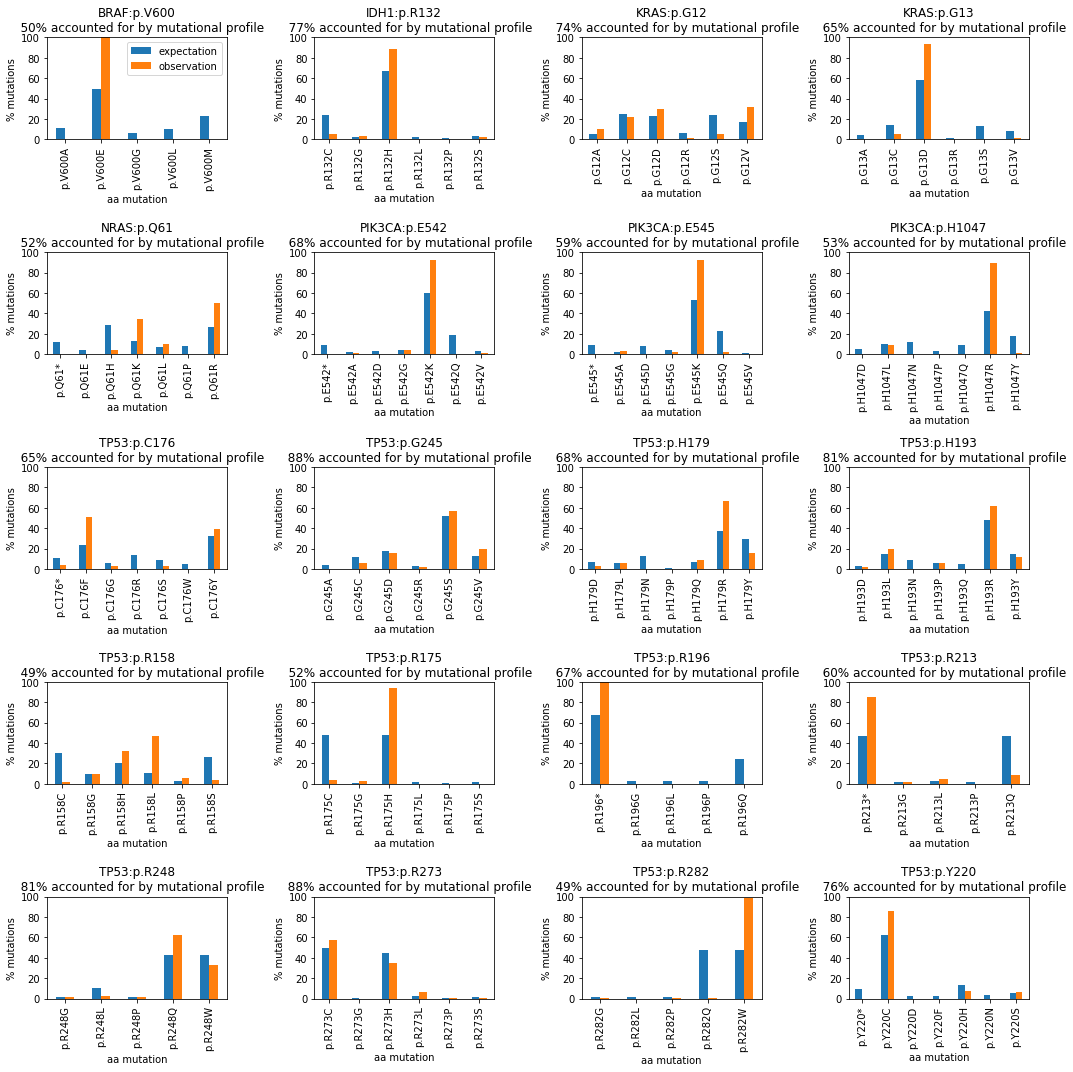

In [840]:
cols = 4
fig,axarr = plt.subplots(5,cols,figsize  =(15,15))
for i,self in enumerate(agms_good):
    if i==0:
        legend = 'full'
    else:
        legend = False
    ax = axarr[i//cols][i%cols]
    self.weighted  = 100*self.get_weights()
    col = 0
    perc_accounted = self.get_perc_accounted(col)
    ax = self.weighted.iloc[:,[col,2]].plot(kind = 'bar',ax = ax,legend = legend)
    ax.set_title('{}\n {:4.2g}% accounted for by mutational profile'.format(self.gene_mut,perc_accounted))
    ax.set_ylabel("% mutations")
    ax.set_ylim(0,100)
if False:
    i+=1
    ax = axarr[i//cols][i%cols]
    ax.set_visible(False)
    
plt.tight_layout()

In [1012]:
for i in range(20):
    a,b,c,d = cosine_test(i)
    print(a,b,c[0],d)

0.8688119785951648 8 0.956360349975677 BRAF:p.V600
0.9599807601334455 0 0.8897868247226952 IDH1:p.R132
0.8623614409891365 144 0.9831897178037149 KRAS:p.G12
0.9513792905444218 0 0.9109794773221899 KRAS:p.G13
0.7237604780782894 123 0.8996575875321919 NRAS:p.Q61
0.9465729605247619 0 0.8778255992662642 PIK3CA:p.E542
0.90645903688626 0 0.8531973348888052 PIK3CA:p.E545
0.8743390246747182 1 0.8871973895528728 PIK3CA:p.H1047
0.8752756647959273 7 0.940041849863134 TP53:p.C176
0.986284405207048 0 0.951513888720973 TP53:p.G245
0.8754785737682267 2 0.899477154464245 TP53:p.H179
0.9742232651139627 0 0.9525232608895289 TP53:p.H193
0.5090428767444489 749 0.9820322866705194 TP53:p.R158
0.7352359760685312 27 0.9036837045724145 TP53:p.R175
0.9374106731274555 2 0.9776697560518068 TP53:p.R196
0.7759805360035915 52 0.9481249424948883 TP53:p.R213
0.9470520689425307 8 0.9772380656339245 TP53:p.R248
0.9818159132521453 0 0.9728215042888634 TP53:p.R273
0.7108019603359066 60 0.950933074639389 TP53:p.R282
0.97831

In [974]:
cos_sim = lambda x,y:    (x*y).sum()/math.sqrt((x*x).sum()*(y*y).sum())

In [1009]:
def cosine_test(num):
    self = agms_good[num]
    shape = self.weighted.shape[0]
    index = self.weighted.index
    #make 1000 random cosines and sort them
    random_cosines = sorted([cos_sim(pd.Series(np.random.rand(shape),index = index),
                              self.weighted['observation']) for i in range(1000)])[::-1]
    #see where our expected value comes in this list.
    obs_cosine = cos_sim(self.weighted['expectation'],self.weighted['observation'])
    pos = random_cosines.index(next(i for i in random_cosines if i<obs_cosine))
    
    return obs_cosine,pos, random_cosines, self.gene_mut

In [1008]:
self = agms_good[2]

In [1004]:
num = 2
self = agms_good[num]
shape = self.weighted.shape[0]
index = self.weighted.index
#make 1000 random cosines and sort them
random_cosines = sorted([cos_sim(pd.Series(np.random.rand(shape),index = index),
                          self.weighted['observation']) for i in range(1000)])[::-1]
#see where our expected value comes in this list.
obs_cosine = cos_sim(self.weighted['expectation'],self.weighted['observation'])

In [863]:
set_common_partials

{'BRAF:p.V600',
 'IDH1:p.R132',
 'KRAS:p.G12',
 'KRAS:p.G13',
 'NRAS:p.Q61',
 'PIK3CA:p.E542',
 'PIK3CA:p.E545',
 'PIK3CA:p.H1047',
 'TP53:p.C176',
 'TP53:p.G245',
 'TP53:p.H179',
 'TP53:p.H193',
 'TP53:p.R155',
 'TP53:p.R158',
 'TP53:p.R175',
 'TP53:p.R196',
 'TP53:p.R213',
 'TP53:p.R248',
 'TP53:p.R273',
 'TP53:p.R282',
 'TP53:p.Y220'}

In [958]:
partial = 'TP53:p.R158'

def comp(partial):
    self = AllGeneMuts(partial)

    self.weights = self.get_weights()

    expectations = self.weights['expectation'].cumsum()


    size = sample_size(partial)[1]

    def aa(x):
        greater = (expectations-x)>0
        return greater[greater].index[0]

    random_obs = pd.concat([(pd.Series([aa(x) for x in np.random.rand(size)]).value_counts()/size).reindex(expectations.index).fillna(0) \
    for i in range(1000)],axis = 1)

    obs = pd.DataFrame(self.weights['observation']).T

    def sortv(series):
        x = series.sort_values()
        x.index = series.index
        return x

    random_obs = random_obs.apply(sortv,axis = 1)

    low_high = random_obs[[10,990]].T

    low_high.index = ['low','high']

    low_high=low_high.append(obs)

    comparison = pd.concat([low_high.loc['low']-low_high.loc['observation'],
                      low_high.loc['observation']-low_high.loc['high']],axis=1).T.applymap(lambda x:x>0)

    comparison.index = ['low>obs','high<obs']

    return comparison

In [961]:
scp.index('TP53:p.H193')

11

In [ ]:
comp

In [964]:
comps[partial]

aa mutation  p.Y220*  p.Y220C  p.Y220D  p.Y220F  p.Y220H  p.Y220N  p.Y220S
low>obs         True    False    False    False     True     True    False
high<obs       False     True    False    False    False    False    False

In [997]:
for partial in scp[:11]:
    try:
        comps[partial] = comp(partial)
        print(partial)
        print(comps[partial])
    except AttributeError:
        pass

/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


BRAF:p.V600
aa mutation  p.V600A  p.V600E  p.V600G  p.V600L  p.V600M
low>obs         True    False     True     True     True
high<obs       False     True    False    False    False
IDH1:p.R132
aa mutation  p.R132C  p.R132G  p.R132H  p.R132L  p.R132P  p.R132S
low>obs         True    False    False     True    False    False
high<obs       False    False     True    False    False    False
KRAS:p.G12
aa mutation  p.G12A  p.G12C  p.G12D  p.G12R  p.G12S  p.G12V
low>obs       False   False   False    True    True   False
high<obs       True   False    True   False   False    True
KRAS:p.G13
aa mutation  p.G13A  p.G13C  p.G13D  p.G13R  p.G13S  p.G13V
low>obs        True    True   False   False    True    True
high<obs      False   False    True   False   False   False
NRAS:p.Q61
aa mutation  p.Q61*  p.Q61E  p.Q61H  p.Q61K  p.Q61L  p.Q61P  p.Q61R
low>obs        True    True    True   False   False    True   False
high<obs      False   False   False    True   False   False    True
PIK3CA:p.E

In [962]:
for partial in scp[11:]:
    try:
        comps[partial] = comp(partial)
        print(partial)
        print(comps[partial])
    except AttributeError:
        pass

/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TP53:p.H193
aa mutation  p.H193D  p.H193L  p.H193N  p.H193P  p.H193Q  p.H193R  p.H193Y
low>obs        False    False     True    False     True    False    False
high<obs       False    False    False    False    False     True    False
TP53:p.R158
aa mutation  p.R158C  p.R158G  p.R158H  p.R158L  p.R158P  p.R158S
low>obs         True    False    False    False    False     True
high<obs       False    False     True     True    False    False


/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



TP53:p.R175
aa mutation  p.R175C  p.R175G  p.R175H  p.R175L  p.R175P  p.R175S
low>obs         True    False    False     True    False    False
high<obs       False    False     True    False    False    False
TP53:p.R196
aa mutation  p.R196*  p.R196G  p.R196L  p.R196P  p.R196Q
low>obs        False    False    False    False     True
high<obs        True    False    False    False    False
TP53:p.R213
aa mutation  p.R213*  p.R213G  p.R213L  p.R213P  p.R213Q
low>obs        False    False    False    False     True
high<obs        True    False    False    False    False
TP53:p.R248
aa mutation  p.R248G  p.R248L  p.R248P  p.R248Q  p.R248W
low>obs        False     True    False    False     True
high<obs       False    False    False     True    False
TP53:p.R273
aa mutation  p.R273C  p.R273G  p.R273H  p.R273L  p.R273P  p.R273S
low>obs        False    False     True    False    False    False
high<obs        True    False    False     True    False    False
TP53:p.R282
aa mutation  p.R282

In [864]:
scp = sorted(list(set_common_partials))

/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [860]:
def sample_size(partial):
    thepartial =  Data.partials().loc[Data.partials()['partial_mutation']==partial]


    return [partial,len(thepartial['Sample name']),thepartial['complete_mutation'].value_counts()]

In [861]:
pd.DataFrame([sample_size(p) for p in scp])

0    1                                                  2
0      BRAF:p.V600  409  BRAF:p.V600E    409
Name: complete_mutation, d...
1      IDH1:p.R132  283  IDH1:p.R132H    222
IDH1:p.R132C     38
IDH1:p...
2       KRAS:p.G12  536  KRAS:p.G12D    178
KRAS:p.G12V    162
KRAS:p.G...
3       KRAS:p.G13  110  KRAS:p.G13D    96
KRAS:p.G13C    10
KRAS:p.G13...
4       NRAS:p.Q61  154  NRAS:p.Q61R    78
NRAS:p.Q61K    54
NRAS:p.Q61...
5    PIK3CA:p.E542  244  PIK3CA:p.E542K    221
PIK3CA:p.E542V      8
PI...
6    PIK3CA:p.E545  434  PIK3CA:p.E545K    391
PIK3CA:p.E545A     15
PI...
7   PIK3CA:p.H1047  429  PIK3CA:p.H1047R    364
PIK3CA:p.H1047L     51
...
8      TP53:p.C176  115  TP53:p.C176F    60
TP53:p.C176Y    43
TP53:p.C...
9      TP53:p.G245  155  TP53:p.G245S    83
TP53:p.G245V    29
TP53:p.G...
10     TP53:p.H179  126  TP53:p.H179R    81
TP53:p.H179Y    20
TP53:p.H...
11     TP53:p.H193  131  TP53:p.H193R    77
TP53:p.H193L    20
TP53:p.H...
12     TP53:p.R155  115  TP53:p.R155Q    65
TP53:p.R155W    41
TP53:p.R...
13     TP53:p.R158  114  TP53:p.R158H    54
TP53:p.R158L    32
TP53:p.R...
14     TP53:p.R175  327  TP53:p.R175H    297
TP53:p.R175G     20
TP53:p...
15     TP53:p.R196  114  TP53:p.R196*    114
Name: complete_mutation, d...
16     TP53:p.R213  182  TP53:p.R213*    142
TP53:p.R213Q     28
TP53:p...
17     TP53:p.R248  455  TP53:p.R248Q    263
TP53:p.R248W    155
TP53:p...
18     TP53:p.R273  407  TP53:p.R273C    197
TP53:p.R273H    160
TP53:p...
19     TP53:p.R282  141  TP53:p.R282W    131
TP53:p.R282R      3
TP53:p...
20     TP53:p.Y220  151  TP53:p.Y220C    131
TP53:p.Y220S     12
TP53:p...

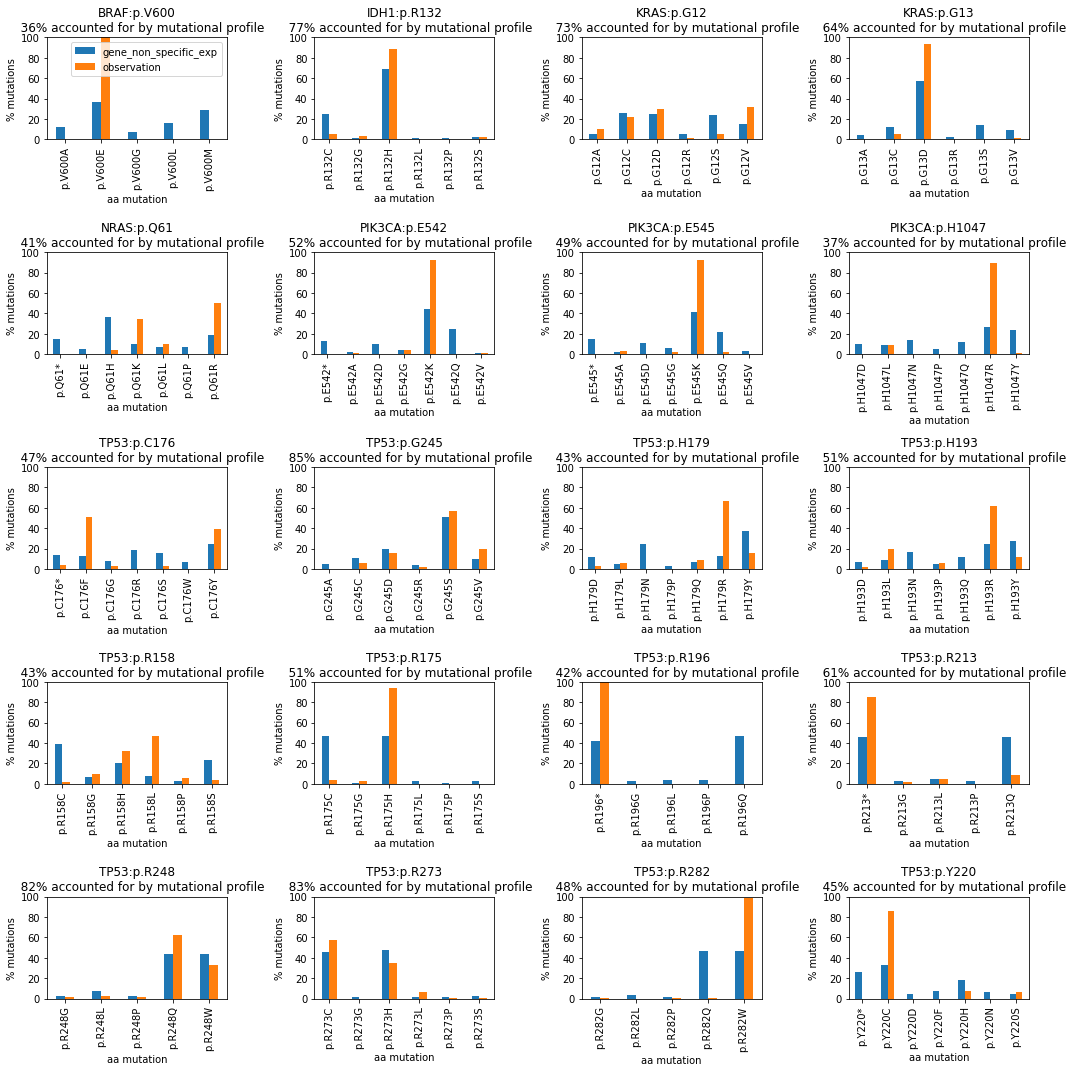

In [842]:
cols = 4
fig,axarr = plt.subplots(5,cols,figsize  =(15,15))
for i,self in enumerate(agms_good):
    if i==0:
        legend = 'full'
    else:
        legend = False
    ax = axarr[i//cols][i%cols]
    self.weighted  = 100*self.get_weights()
    col = 1
    perc_accounted = self.get_perc_accounted(col)
    ax = self.weighted.iloc[:,[col,2]].plot(kind = 'bar',ax = ax,legend = legend)
    ax.set_title('{}\n {:4.2g}% accounted for by mutational profile'.format(self.gene_mut,perc_accounted))
    ax.set_ylabel("% mutations")
    ax.set_ylim(0,100)
if False:
    i+=1
    ax = axarr[i//cols][i%cols]
    ax.set_visible(False)
    
plt.tight_layout()

In [841]:
fig.savefig('perc_mutations_accounted_by_profile.pdf')

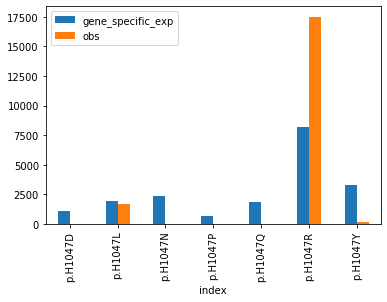

In [699]:
sp.apply(weight,axis = 1).iloc[:,[2,4]].plot(kind = 'bar')

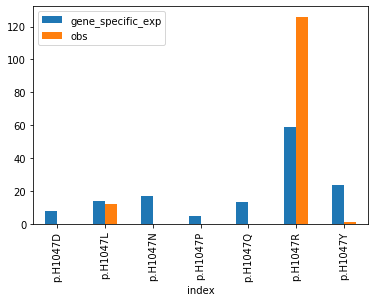

In [679]:
sp.iloc[:,[2,4]].plot(kind = 'bar')

In [263]:
class Results:
    gm_groups = pd.Series(Data.common_partials().groupby(by = 'partial_mutation').groups)\
    .map(lambda x: list(Data.common_partials()['partial_mutation_full_name'].reindex(x).drop_duplicates()))
    
    conv = converter.multi_converter
    
    log = lambda x: np.nan if x<=0 else math.log2(x)
    gray = to_rgba('gray')
    
    color_options = [plt.get_cmap('rainbow')(40*i) for i in range(20)]
    
    def oe_ratio(row):
        
        r = row.reset_index()
        r0 = r.pivot(index = 'level_0',columns = 'level_1',values = r.columns[2])

        r1= r0['obs']/r0['exp']
        r1.name = row.name
        return r1
   

    
    
    
    def __init__(self,short_mut,n):
        self.n = n
        self.short_mut = short_mut #shortname of the partial mutation eg 'TP53p.R248'
        

        self.list = Results.gm_groups[short_mut] 
        #all the long names corresponding to the mutation - including different ensts
        gms = [Gene_mut(i) for i in self.list] #gathering the information for each of the long names
        self.gms=gms
        comp = List([i.comparison for i in gms]).Sum() # for each AA change / cancer site, 
        #the number of samples affected across all the transcript variants
        comp = comp.loc[comp.T.sum()>=30].astype(int) 
        # skinnied down to just those sites with more than 30 mutations

        oe_tog = lambda site: List([i.predict(site) for i in gms]).Sum()
        #predictions for a site for each of the AA changes for all of the transcript variants

        a = next((i for i in gms if type(i.codon)!=float))
        self.gene = a.gene.split('_')[0]
        self.mutation = '''{}_{}{}'''.format(a.gene.split('_')[0],a.wild,a.aa_pos)
        #formatting of the mutation

        self.refseq = list(Results.conv.loc[Results.conv['Gene name']==self.gene]\
                           ['Peptides'].dropna().drop_duplicates())

        sites = comp.index #the list of sites with 30 or more mutated samples

        #self.oe is the complete dataframe of predictions/observations for each site, for each transcript.
        self.oe = pd.concat(dict([(site,oe_tog(site)) for site in sites]),axis = 1)
        cols = self.oe.columns.levels[0]
        self.sample_sizes = (pd.concat([self.oe[i]['obs'] for i in cols],axis=1).sum()).astype(int)
        self.sample_sizes.index= cols


        #ratio of observation/prediction
        self.oe_ratios = pd.DataFrame([Results.oe_ratio(self.oe.iloc[i]) for i in range(self.oe.shape[0])]).fillna(0)

        self.sites = list(self.oe.columns.levels[0])
        self.possible_mutations = list(self.oe.index)
        self.mutations  = ['{},{}'.format(self.gene,i.split('.')[1]) for i in self.possible_mutations]

        self.num_sites = len(self.sites)

        self.aas = self.oe.index
        self.num_AAs = len(self.aas)
        self.colors = Results.color_options[:self.num_sites] #the colours we need to cover our sites
        self.set_range_ratios()
        self.log_ratios = self.range_ratios_df.applymap(Results.log)
        self.observed = self.get_observed()

        self.fasta = Results.conv.loc[Results.conv['Gene name']==self.gene]['Nucleotides'].iloc[0]

        

    def get_weighted(self):
    
        u_m_l = self.log_ratios.apply(get_u_m_l)
        weighted = u_m_l.iloc[:-1]*u_m_l.loc['weight']
        weighted = weighted.append(u_m_l.loc['weight'])
        weighted = weighted.T.reindex()
        weighted = weighted.groupby(level=0).sum()
        weighted = weighted.iloc[:,:-1].apply(lambda col: col/weighted['weight'])
        return weighted
        
    def get_random_ratios(self,site):
    
        '''Identifies for a site the potential range of expected result given the number of samples and the 
        number of experiments'''

        site_results = self.oe[site]

        obs = site_results['obs']
        exp = site_results['exp']
        index = site_results.index

        site_0 = pd.Series(0,obs.loc[obs==0].index)
        positive = site_results.loc[obs>0]
        pos_index = positive.index
        sample_size = int(obs.sum())

        exp_cumsum = (exp/exp.sum()).cumsum()
        rand_mut = np.vectorize(lambda x: exp_cumsum[exp_cumsum>x].index[0]) 
        random_ratio = lambda : (obs/pd.Series(rand_mut(np.random.rand(sample_size))).value_counts())[pos_index]
        random_ratios = pd.DataFrame([pd.concat([random_ratio(),site_0]).reindex(index) for i in range(self.n)])
        return random_ratios.fillna(random_ratios.max().max()) 
        
    def set_range_ratios(self):
        
        range_ratios = {}
        for site in self.sites:
            range_ratios[site] = self.get_random_ratios(site)

        range_ratios_df = pd.concat(range_ratios,axis = 1).T
        range_ratios_df = range_ratios_df.swaplevel()
        range_ratios_df = range_ratios_df.reindex(range_ratios_df.index.sort_values()).T    
        range_ratios_df = range_ratios_df[self.aas] #this step needs adding in to make them turn up in the right order.
        
        self.range_ratios_df = range_ratios_df
        
    def mutass(self):
    
        print( '\n'.join([i + '\t' +j.split('.')[1] for i in self.refseq for j in self.possible_mutations]))
        
    def get_observed(self):
        cols = self.oe.columns.levels[0]
        observed = pd.concat([self.oe[i]['obs'] for i in cols],axis = 1).astype(int)
        observed.columns = cols
        return observed

    def show_observed(self,ax):
        ax = self.observed.T.plot.barh(ax = ax)
        legend = ax.legend(loc = (1.01,0),fontsize = 14)
        _= ax.set_title(self.mutation,fontsize = 28)

        return ax
      
    def show_ratios(self,ax):
        fig,ax = plt.subplots(figsize = (10,5))
        ax = self.oe_ratios.plot.bar(ax = ax)
        legend=ax.legend(loc = (1.01,0),fontsize = 14)
        line = ax.axhline(y=1)
        ax.set_title(self.mutation,fontsize = 28)
        
        
    def show_forest_plots(self,axarr):
        mutations = self.log_ratios.columns.levels[0]
        self.uml = self.log_ratios.apply(get_u_m_l)
        mx = max(abs(self.uml.T.max()['upper']),abs(self.uml.T.min()['lower']))
        self.xlim = (-mx,mx)

        for i,m in enumerate(mutations):
            experimental_df = self.log_ratios[m]
            sample_sizes = self.sample_sizes
            title = m
            axarr[i] = forest_plot(experimental_df,sample_sizes,ax=axarr[i],
                                           title = title,xlim = self.xlim)
        return axarr

    def show_all(self,ax):
        mixed_colors = []
        for i in range(self.num_sites):
            mixed_colors+=[self.colors[i],Results.gray]
        mixed_colors*= self.num_AAs
        ax = self.oe.plot.barh(ax = ax, width = 0.8, color = mixed_colors)
        legend = ax.legend(loc=(1.01,0),fontsize = 14)

        return ax
    
    def show(self):
        fig,axarr = plt.subplots(self.num_AAs+3, figsize = (10,self.num_AAs*5+1))

        axarr[0] = self.show_observed(axarr[0])
        axarr[1].set_axis_off()################ make axes invisible
        axarr[2]=self.show_all(axarr[2])
        axarr[3:]= self.show_forest_plots(axarr[3:])

    
    # The next section deals with strings to be input into the webbrowsers and automatic identification
    # of ma scores and fatthm scores.
    
    def fasta_string(self,i=None):
        if i:
            w,m = i[2],i[-1]
            pos = int(i[3:-1])-1
            fasta = self.fasta[:pos]+m+self.fasta[pos+1:]

        else:
            fasta = self.fasta
            m = ''
        fasta = '\n'.join([fasta[i*60:(i+1)*60] for i in range(len(fasta)//60+1)])
        string = '''>{}{}\n{}'''.format(self.mutation,m,fasta)
        return string

    def netsurfp_input(self):
        return '\n'.join([self.fasta_string()]+[self.fasta_string(i) for i in self.possible_mutations])
            
    def ma_scores(self):   
        return ma.score(self.mutations)
    
    def polyphen_input(self):
        return '\n'.join(['{} {} {} {}'.format(self.refseq[0],i[1:-1],i[0],i[-1]) for i in muts])


In [292]:
commonps = list(set_common_partials)

In [303]:
print(commonps)

['PIK3CA:p.H1047', 'TP53:p.H193', 'TP53:p.H179', 'IDH1:p.R132', 'TP53:p.R175', 'KRAS:p.G12', 'TP53:p.Y220', 'TP53:p.G245', 'TP53:p.R273', 'TP53:p.C176', 'NRAS:p.Q61', 'TP53:p.R248', 'TP53:p.R196', 'TP53:p.R213', 'PIK3CA:p.E542', 'TP53:p.R282', 'PIK3CA:p.E545', 'TP53:p.R158', 'TP53:p.R155', 'BRAF:p.V600', 'KRAS:p.G13']


valueerror
only one site with enough data
only one site with enough data
only one site with enough data


/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


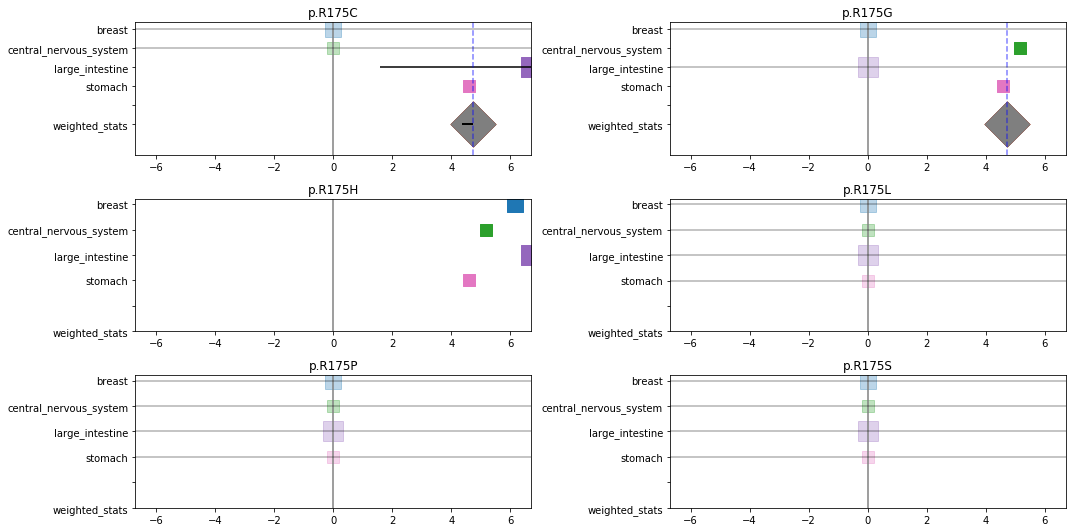

TP53:p.R175


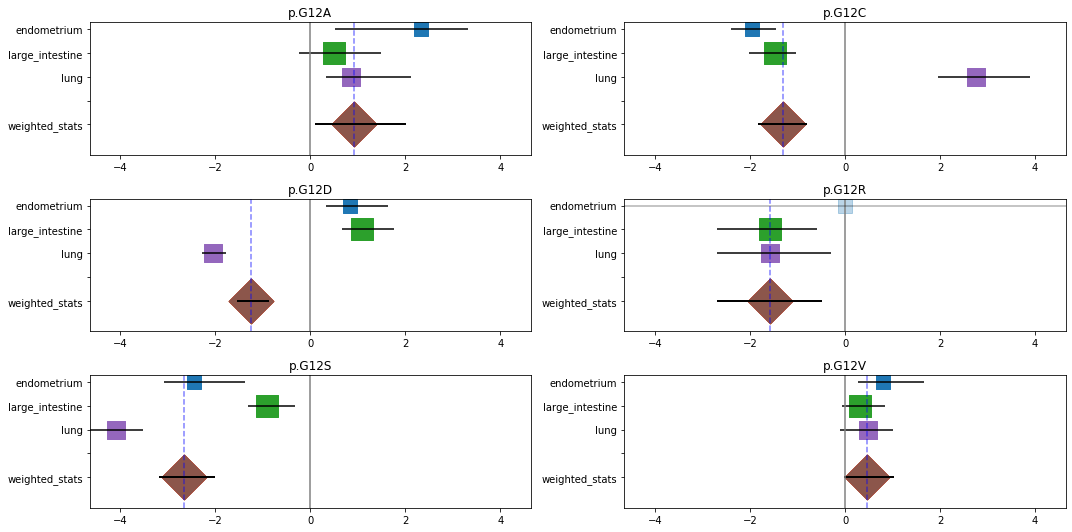

KRAS:p.G12


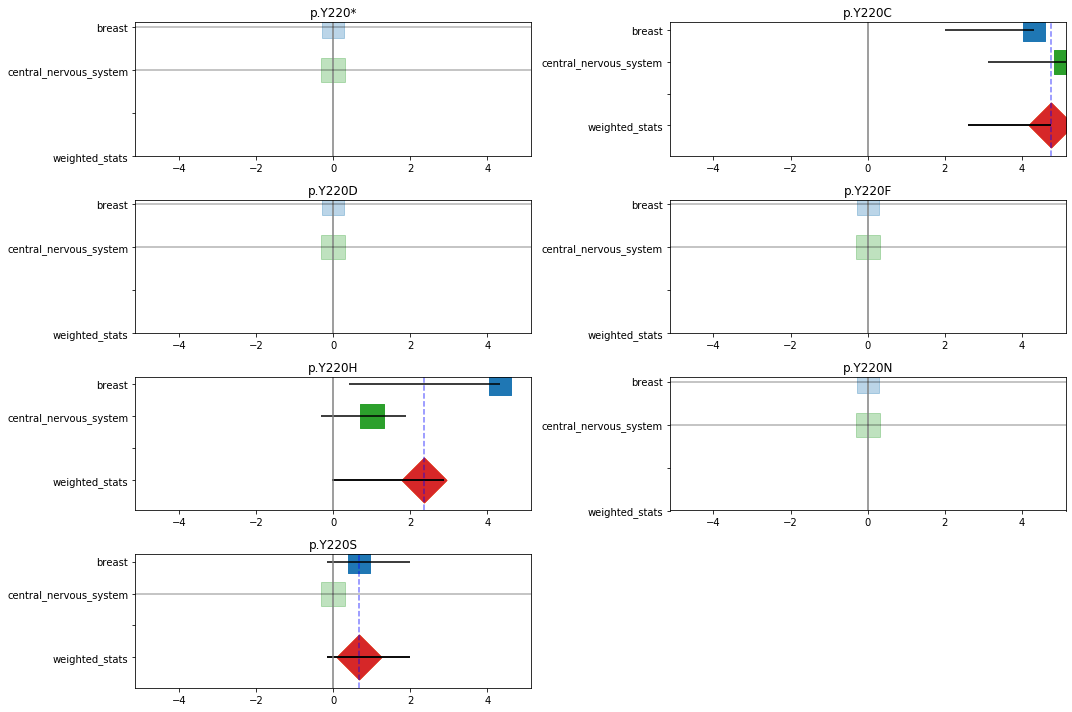

TP53:p.Y220
only one site with enough data


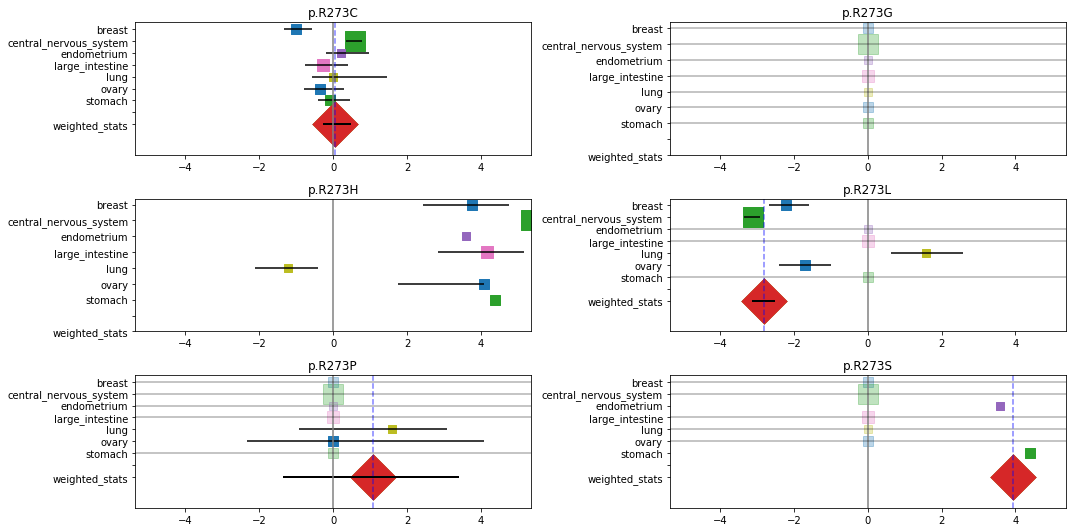

TP53:p.R273
valueerror


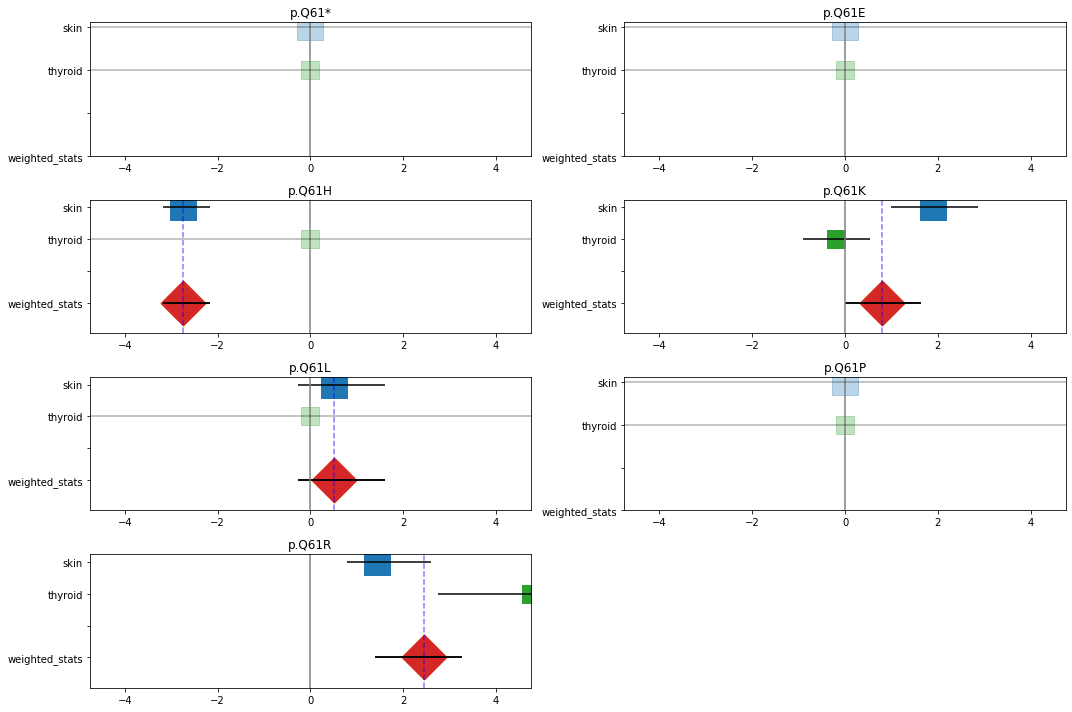

NRAS:p.Q61


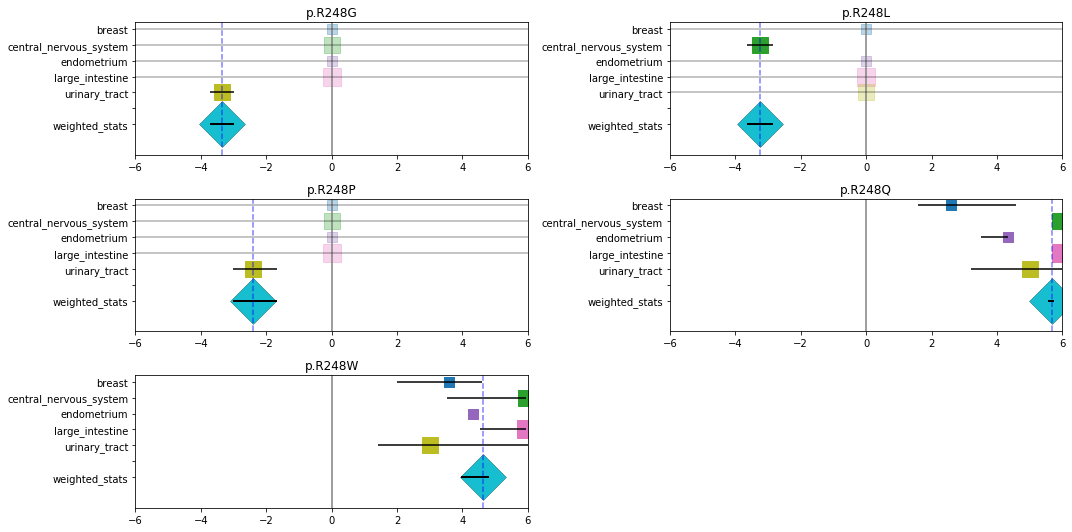

TP53:p.R248


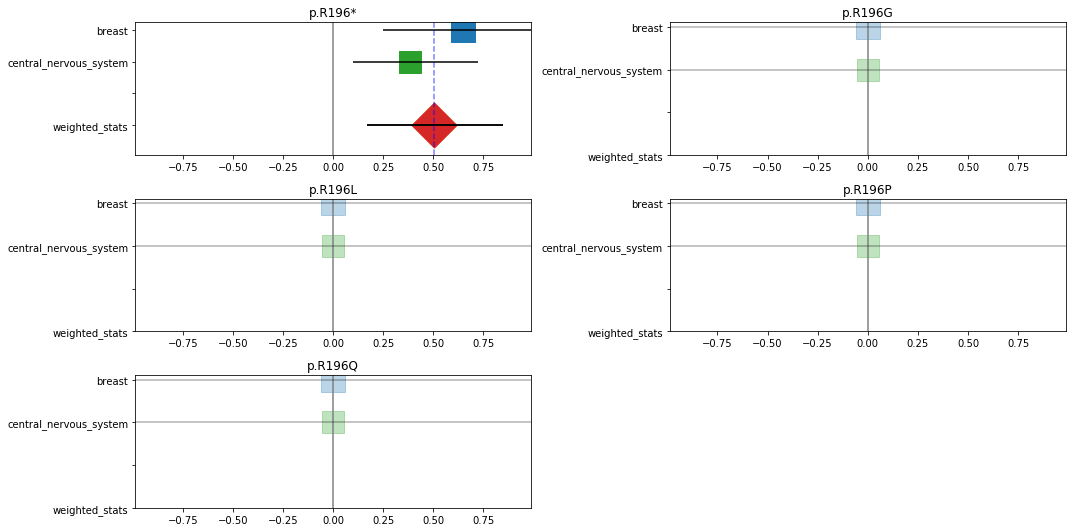

TP53:p.R196
only one site with enough data
valueerror
valueerror
valueerror
only one site with enough data
keyerror


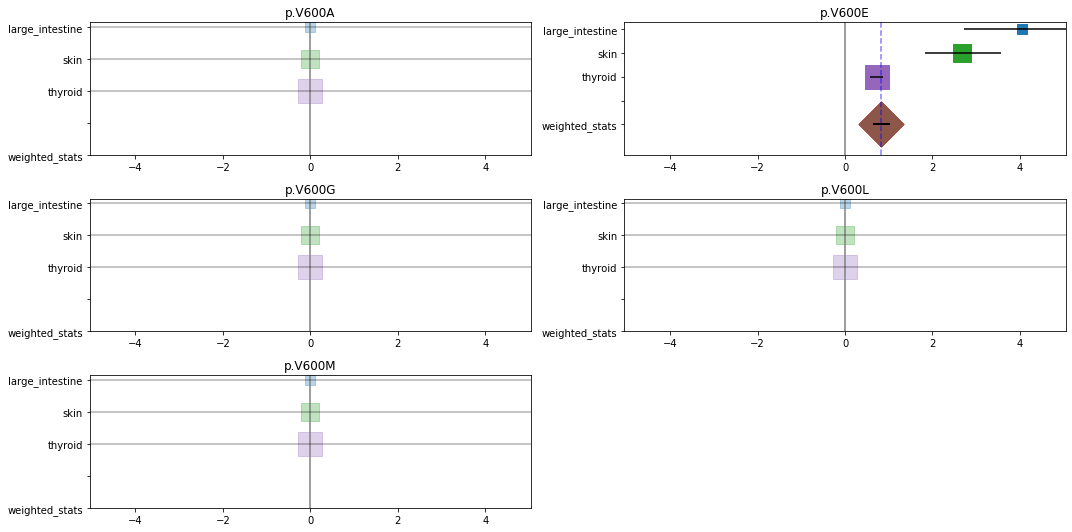

BRAF:p.V600
only one site with enough data


In [340]:
for partial in commonps:


    n = 50

    try:
        self = Results(partial,n)


        #def show_forest_plots(self):

        if self.sample_sizes.shape[0]>1:
            mutations = self.log_ratios.columns.levels[0]
            self.uml = self.log_ratios.apply(get_u_m_l)
            mx = max(abs(self.uml.T.max()['upper']),abs(self.uml.T.min()['lower']))
            self.xlim = (-mx,mx)
            length = len(mutations)
            rows = length//2+length%2
            fig,axarr = plt.subplots(rows,2,figsize = (15,rows*2.5))


            for i,m in enumerate(mutations):
                experimental_df = self.log_ratios[m]
                sample_sizes = self.sample_sizes
                title = m
                ax = axarr[i//2][i%2]
                ax = forest_plot(experimental_df,sample_sizes,ax=ax,
                                               title = title,xlim = self.xlim)
            if length%2==1:
                i = length
                ax = axarr[i//2][i%2]
                ax.set_visible(False)
            plt.tight_layout()
            plt.show()
            print(partial)
        else:
            print('only one site with enough data')

    except ValueError:
        print('valueerror')
    except KeyError:
        print('keyerror')

In [307]:
Data.common_partials().loc[Data.common_partials()['partial_mutation']=='BRAF:p.V600']['complete_mutation'].value_counts()

BRAF:p.V600E    409
Name: complete_mutation, dtype: int64

In [204]:
mylist =Results.gm_groups.iloc[0]

In [211]:
def show_distinction(mylist, individually = False, together = False, ratio = False):
    gms = [Gene_mut(i) for i in mylist]
    comp = List([i.comparison for i in gms]).Sum()
    oe_tog = lambda site: List([i.predict(site) for i in gms]).Sum()
    comp = comp.loc[comp.T.sum()>29].astype(int)
    sites = comp.index
    a = next((i for i in gms if type(i.codon)!=float))
    mutation = '''{}_{}{}'''.format(a.gene.split('_')[0],a.wild,a.aa_pos)
    
    if individually:
        fig,axarr = plt.subplots(len(sites),figsize = (5,30))
        for i,site in enumerate(sites):

            oe = oe_tog(site)
            oe.plot.bar(ax = axarr[i])
            axarr[i].set_title('{} - sample size = {}'.format(site,comp.T.sum().loc[site]))

        title = 'Distribution Amino Acids {}'.format(mutation)
        
        fig.suptitle(title, y = 1.01, fontsize = 14)
        plt.tight_layout()
        title = 'Distn_aas_{}.pdf'.format(mutation)
        #plt.savefig(title)
        
        plt.show()

    if together:
        oe = pd.concat(dict([(site,oe_tog(site)) for site in sites]),axis = 1)
        fig,ax = plt.subplots(figsize = (10,5))
        colours = ['blue','orange']*40
        ax = oe.plot.bar(ax = ax, width = 0.8, color = colours)
        legend = ax.legend(loc=(1.01,0),fontsize = 14)

        ax.set_title(mutation,fontsize = 28)
    
    if ratio:
        oe_ratios = pd.DataFrame([Results.oe_ratio(oe.iloc[i]) for i in range(oe.shape[0])]).fillna(0)
        fig,ax = plt.subplots(figsize = (10,5))
        ax = oe_ratios.plot.bar(ax = ax)
        legend=ax.legend(loc = (1.01,0),fontsize = 14)
        line = ax.axhline(y=1)
    
    return oe

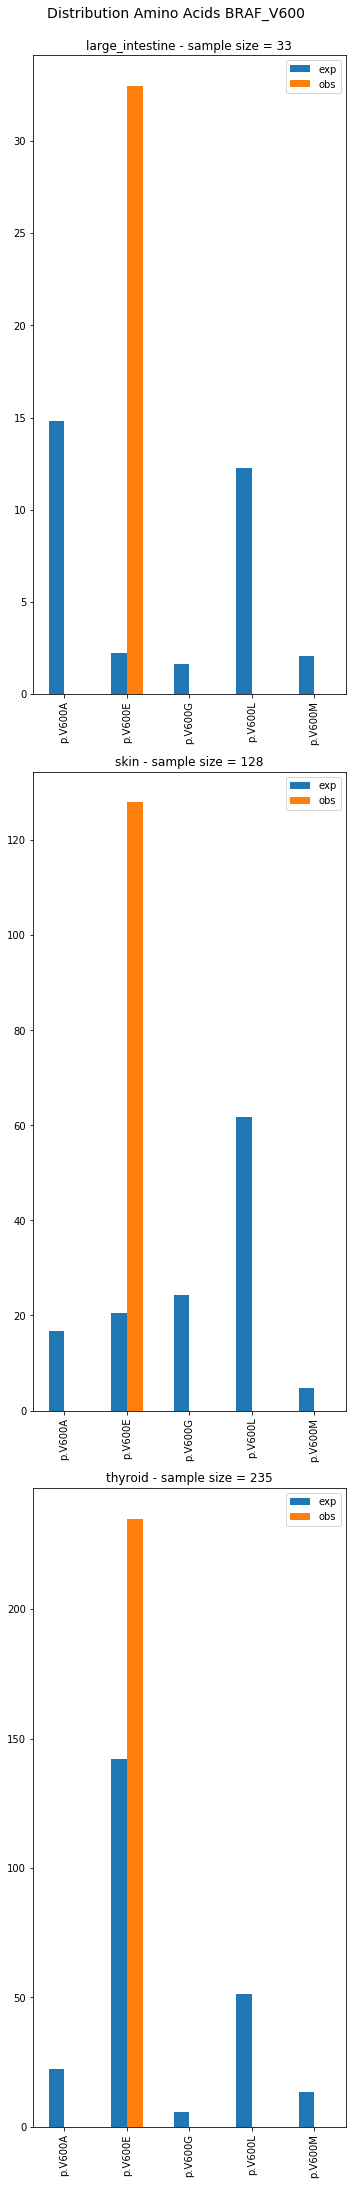

IndexError: index 2 is out of bounds for axis 0 with size 2

In [213]:
show_distinction(mylist,individually = True,ratio = True)